# Simulated single cell expression data with ambient contamination

This example uses TACCO to annotate simulated single cell data, simulated using a modified variant (Moriel) of scsim (Kotliar).

(Moriel): Moriel, N. Extension of scsim single-cell RNA-sequencing data simulations. github.com/nitzanlab/scsim-ext (2023)

(Kotliar): Kotliar, D. scsim: simulate single-cell RNA-SEQ data using the Splatter statistical framework but implemented in python. github.com/dylkot/scsim (2021)

In [1]:
import os
import sys
import matplotlib

import pandas as pd
import numpy as np
import scanpy as sc

import tacco as tc
from scsim import scsim

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

In [2]:
env_path = common_code.find_path('results/env_links')

## Simulate single cell data

Simulate data with various dropout levels with a known ground truth

In [3]:
ngenes = 25000
descale = 1.0
ndoublets = 100
K = 13
nproggenes = 1000
proggroups = [1,2,3,4]
progcellfrac = .35
ncells = 1500
deprob = .025

libloc=7.64
libscale=0.78

deloc = 5.0

seed=2

# simulating true counts (in simulator.counts)
simulator = scsim(ngenes=ngenes, ncells=ncells, ngroups=K, libloc=libloc, libscale=libscale,
             mean_rate=7.68,mean_shape=0.34, expoutprob=0.00286,
             expoutloc=6.15, expoutscale=0.49,
             diffexpprob=deprob, diffexpdownprob=0., diffexploc=deloc, diffexpscale=descale,
             bcv_dispersion=0.448, bcv_dof=22.087, ndoublets=ndoublets,
             nproggenes=nproggenes, progdownprob=0., progdeloc=deloc,
             progdescale=descale, progcellfrac=progcellfrac, proggoups=proggroups,
             cellbender=True, cb_ambient=False, #cb_droploc=0, cb_dropscale=1, 
                  cb_dispshape=1, cb_dispscale=1,
             minprogusage=.1, maxprogusage=.7, seed=seed)
simulator.simulate()

Simulating cells
Simulating gene params
Simulating program
Simulating DE
Simulating cell-gene means
   - Getting mean for activity program carrying cells
   - Getting mean for non activity program carrying cells
   - Normalizing by cell libsize
Simulating doublets
Adjusting means
Simulating counts with cellbender


In [4]:
reference = sc.AnnData(simulator.counts, obs=simulator.cellparams, var=simulator.geneparams[[]])
reference.obs['group'] = reference.obs['group'].astype('category')

In [5]:
# get counts with ambient RNA (cellbender)
simulator.cb_ambient=True

fraclibs = [0.1,0.2,0.3,0.4]

sdatas = {}
for fraclib in fraclibs:
    simulator.cb_fraclib=fraclib
    simulator.simulate_cellbender()

    adata = sc.AnnData(simulator.counts, obs=simulator.cellparams, var=simulator.geneparams[[]])
    adata.obs['group'] = adata.obs['group'].astype('category')

    sdatas[fraclib] = adata

## Plotting options

In [6]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([3,3])*1.0

## Visualize simulated data without ambient RNA

Create UMAP for the simulated data without ambient RNA

SCumap...SCprep...time 2.08986759185791
time 29.57620406150818


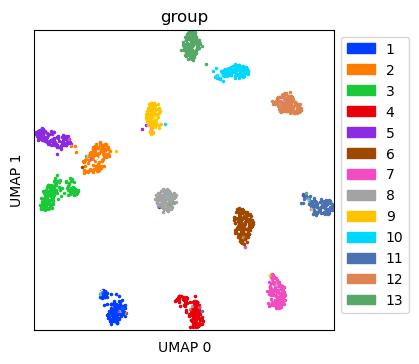

In [7]:
ref_umap = tc.utils.umap_single_cell_data(reference)
fig = tc.pl.scatter(ref_umap, keys='group', position_key='X_umap', joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Visualize simulated data with ambient RNA

Create UMAP for the simulated data with ambient RNA

SCumap...SCprep...time 2.0295157432556152
time 9.373483657836914


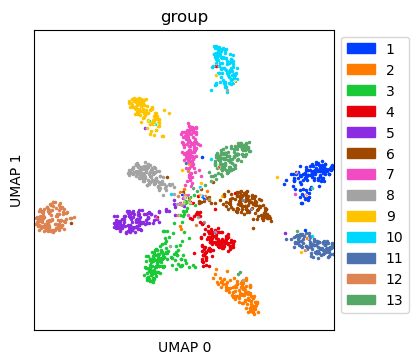

In [8]:
tdata = sdatas[0.4]
tdata_umap = tc.utils.umap_single_cell_data(tdata)
fig = tc.pl.scatter(tdata_umap, keys='group', position_key='X_umap', joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Annotate the data with dropout with cell types

Annotation is done on cell type level with multi_center=10 to capture variation within a cell type

In [9]:
tc.tl.annotate(tdata, reference, 'group', result_key='TACCO', multi_center=10, assume_valid_counts=True)

Starting preprocessing
Annotation profiles were not found in `reference.varm["group"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 3.0 seconds.
Starting annotation of data with shape (1500, 18014) and a reference of shape (1500, 18014) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=group, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  1.5871269020101537 1.1511302432419972
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 18.54 seconds.


AnnData object with n_obs × n_vars = 1500 × 25000
    obs: 'group', 'libsize', 'has_program', 'program_usage', 'is_doublet', 'group2'
    uns: 'TACCO_mc10'
    obsm: 'TACCO_mc10', 'TACCO'
    varm: 'TACCO_mc10'

## Benchmark annotation methods on the simulated dropout data

Define parameters for the annotation methods to use

In [10]:
methods = {
    'NMFreg':{'method': 'NMFreg',},
    'RCTD':{'method': 'RCTD', 'conda_env': f'{env_path}/RCTD_env',},
    'SVM':{'method':'svm',},
    'SingleR':{'method':'SingleR', 'conda_env': f'{env_path}/SingleR_env',},
    'WOT':{'method': 'WOT',},
    'TACCO': {'method': 'OT', 'multi_center': 10,},
}

In [11]:
results = {}
for fraclib in fraclibs:
    for method,params in methods.items():
        print(f'running method {method} for fraclib {fraclib} ...', end='')
        try:
            results[(fraclib,method)] = tc.benchmarking.benchmark_annotate(sdatas[fraclib],reference,annotation_key='group',**params, assume_valid_counts=True);
        except:
            pass # catch failing methods
        print(f'done')

running method NMFreg for fraclib 0.1 ...done
running method RCTD for fraclib 0.1 ...done
running method SVM for fraclib 0.1 ...done
running method SingleR for fraclib 0.1 ...done
running method WOT for fraclib 0.1 ...done
running method TACCO for fraclib 0.1 ...done
running method NMFreg for fraclib 0.2 ...done
running method RCTD for fraclib 0.2 ...done
running method SVM for fraclib 0.2 ...done
running method SingleR for fraclib 0.2 ...done
running method WOT for fraclib 0.2 ...done
running method TACCO for fraclib 0.2 ...done
running method NMFreg for fraclib 0.3 ...done
running method RCTD for fraclib 0.3 ...done
running method SVM for fraclib 0.3 ...done
running method SingleR for fraclib 0.3 ...done
running method WOT for fraclib 0.3 ...done
running method TACCO for fraclib 0.3 ...done
running method NMFreg for fraclib 0.4 ...done
running method RCTD for fraclib 0.4 ...done
running method SVM for fraclib 0.4 ...done
running method SingleR for fraclib 0.4 ...done
running method W

In [12]:
for (fraclib,method),result in results.items():
    unused_key = tc.utils.find_unused_key(sdatas[fraclib].obsm)
    sdatas[fraclib].obsm[unused_key] = results[(fraclib,method)]['annotation']
    max_correct = tc.ev.compute_err(sdatas[fraclib], unused_key, 'group', err_method='max_correct')[unused_key]
    del sdatas[fraclib].obsm[unused_key]
    results[(fraclib,method)]['max_correct'] = max_correct

In [13]:
res_df = pd.DataFrame([
    [fraclib,method,v['max_correct'],v['max_mem_usage_GB'],v['benchmark_time_s']]
    for (fraclib,method),v in results.items()
],columns=['fraclib','method','max_correct','memory (GB)','time (s)'])
quantities = [c for c in res_df.columns if c not in ['fraclib','method'] ]
methods = res_df['method'].unique()

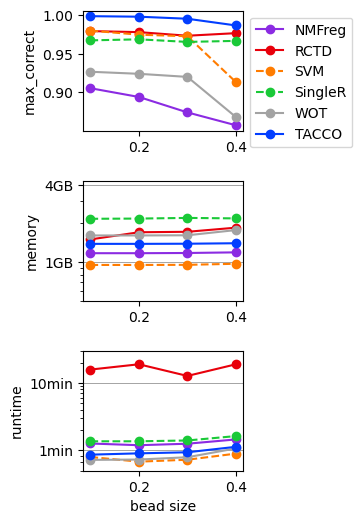

In [14]:
fig,axs = tc.pl.subplots(1,len(quantities), axsize=np.array([4,3])*0.4, x_padding=0.7, y_padding=0.5)
colors = {m:common_code.method_color(m) for m in methods}
styles = {m:common_code.method_style(m) for m in methods}
res_df = res_df.loc[~res_df[quantities].isna().all(axis=1)]
for iy_ax, qty in enumerate(quantities):
    ax = axs[iy_ax,0]

    x = res_df['fraclib']
    y = res_df[qty]

    if qty == 'time (s)': # part 1 of adding second, minute and hour marker: plot the lines under the data

        ynew = np.array([0.1,1,10,60,600,3600,36000])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,60,10),np.arange(60,600,60),np.arange(600,3600,600),np.arange(3600,36000,3600)]).flatten()
        ynewlabels = np.array(['0.1s','1s','10s','1min','10min','1h','10h'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    elif qty == 'memory (GB)':

        ynew = np.array([0.1,0.4,1,4,10,40,100])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100)]).flatten()
        ynewlabels = np.array(['0.1GB','0.4GB','1GB','4GB','10GB','40GB','100GB'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    for m in methods:
        selector = res_df['method'] == m
        if selector.sum() == 0:
            continue
        ax.plot(x[selector],y[selector],label=m,marker='o',color=colors[m],ls=styles[m],)
    if iy_ax == axs.shape[0] - 1:
        ax.set_xlabel('bead size')
    if qty == 'time (s)':
        ax.set_ylabel('runtime')
    elif qty == 'memory (GB)':
        ax.set_ylabel('memory')
    else:
        ax.set_ylabel(f'{qty}')
    if qty in ['time (s)','memory (GB)']:
        ax.set_yscale('log')

    if qty in ['time (s)','memory (GB)']: # part 2 off adding second, minute and hour marker: add the second y axis after rescaling the first y axis to log scale
        ax.set_yticks(ynew_minor,minor=True)
        ax.set_yticks(ynew)
        ax.set_yticklabels(ynewlabels)
        ax.set_yticklabels([],minor=True)

    if iy_ax == 0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)